In [1]:
import sys 
sys.path.append("../")

from models.onu_fuctions import load_un_dataset, create_un_graphs, process_un_graph
import torch 

import torch
from torch_geometric.utils import to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed  


from models.RDPG_GD import GRDPG_GD_Armijo
from models.GLASE_unshared_normalized import gLASE 
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import copy

/home/sofia/lase/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sofia/lase/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sofia/lase/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopyth

# TEST FUNCTIONS

In [ ]:
year = 2018
unknown_countries = 30 
mask_threshold = 0.7

votes_df = load_un_dataset('data/UNVotes-1.csv', unknown_votes=True)

all_graphs = create_un_graphs(votes_df[votes_df.year==year])

adj_matrix, country_indexes, res_indexes, features, missing_countries, mask, inverted_mask_matrix = process_un_graph(all_graphs,countries=unknown_countries, mask_threshold=mask_threshold) 

num_nodes = adj_matrix.shape[0]
edge_index = torch.tensor(adj_matrix).nonzero().t().contiguous()

In [ ]:
## Calculate Embeddings

d = 4

## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
q = torch.Tensor(list_q)
Q=torch.diag(q)

x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()


gd_steps = 20
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)


epochs = 300

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)
        
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)

x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')


masked_edge_index = masked_adj.nonzero().t().contiguous()


In [ ]:
from training.run_link_prediction import link_prediction

data = Data(x=features.float(), x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)
result = link_prediction(edge_index, mask, data, 12, 4)

In [ ]:
torch.manual_seed(42)
random_features=torch.rand([num_nodes, 12])
data = Data(x=random_features.float(), x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

result = link_prediction(edge_index, mask, data, 12, 4)

In [ ]:
from training.run_link_prediction import link_prediction_onu

result = link_prediction_onu(year = 2018, d = 4, unknown_countries = 30, mask_threshold = 0.7, random_features = False)

In [ ]:
from training.run_link_prediction import link_prediction_onu

result = link_prediction_onu(year = 2018, d = 4, unknown_countries = 30, mask_threshold = 0.7, random_features = True)

# ALL YEARS

In [2]:
from training.run_link_prediction import link_prediction_onu
import warnings
warnings.filterwarnings("ignore")

votes_df = load_un_dataset('data/UNVotes-1.csv', unknown_votes=True)

In [3]:
for year in votes_df.year.unique():
    print(f'{year},', end =" ")
    result = link_prediction_onu(year = year, d=4, unknown_countries = 30, mask_threshold = 0.9, random_features=False)

1946, GCN acc: 0.3220, ASE acc: 0.4671, GRDPG acc: 0.4762, GLASE acc: 0.4444
1947, GCN acc: 0.2632, ASE acc: 0.2632, GRDPG acc: 0.4737, GLASE acc: 0.2632
1948, GCN acc: 0.4476, ASE acc: 0.4441, GRDPG acc: 0.4301, GLASE acc: 0.4336
1949, GCN acc: 0.4241, ASE acc: 0.4295, GRDPG acc: 0.4569, GLASE acc: 0.4569
1950, 

KeyboardInterrupt: 

In [4]:
result = link_prediction_onu(year = 1951, d=4, unknown_countries = 30, mask_threshold = 0.7, random_features=False)

GCN acc: 0.0655, ASE acc: 0.0655, GRDPG acc: 0.0655, GLASE acc: 0.0655


In [ ]:
from training.run_link_prediction import link_prediction_onu
votes_df = load_un_dataset('data/UNVotes-1.csv', unknown_votes=True)

for year in votes_df.year.unique():
    print(f'{year},', end =" ")
    acc_gcn, acc_ase, acc_grdpg = link_prediction_onu(year = year, d=4, unknown_countries = 30, mask_threshold = 0.7, random_features=True)

# Specific Countries

In [2]:
import numpy as np
import networkx as nx

year = 1980
mask_threshold = 0.7

votes_df = load_un_dataset('data/UNVotes-1.csv', unknown_votes=True)

G = create_un_graphs(votes_df[votes_df.year==year])
G = G.to_undirected()

# rename nodes
mapping = {node: i for i, node in enumerate(G.nodes())}
G_ = nx.relabel_nodes(G, mapping)

country_indexes = []
res_indexes = []
__features = []

for node, data in G_.nodes(data=True):
    if data["type"] == "country":
        country_indexes.append(node)
        __features.append(data['country_features'])
    else:
        res_indexes.append(node)
        __features.append(data['res_features'])


unknown_edges = []

for u, v, data in G_.edges(data=True):
    if data['unknown']:
        unknown_edges.append((u,v))
        unknown_edges.append((v,u))
    

adj_matrix = nx.adjacency_matrix(G_).todense().astype(int)

_features = np.array(__features)
features = torch.tensor(_features)

/home/sofia/lase/lib/python3.10/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


0 {'country code': 'USA', 'continent': 'North America', 'country_features': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'yellow', 'type': 'country'}
55 {'country code': 'RUS', 'continent': 'Europe', 'country_features': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'royalblue', 'type': 'country'}


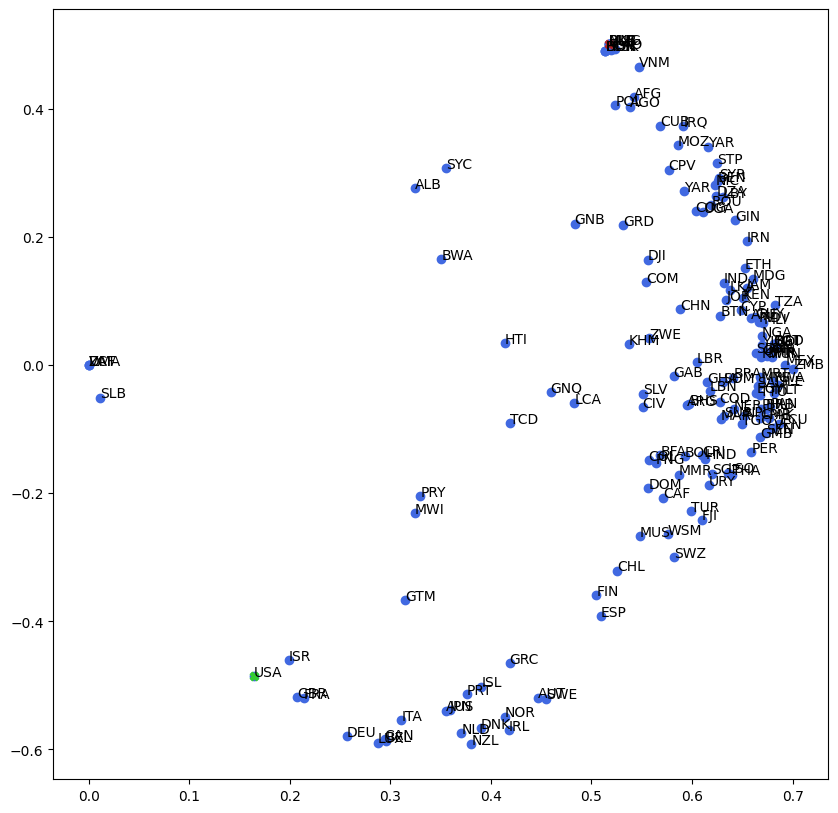

In [3]:
import matplotlib.pyplot as plt

## Calculate ASE Embeddings
d = 4

## ASE 
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase_orig = ase.fit_transform(adj_matrix)

country_labels = []
missing_countries = []
for node, data in G_.nodes(data=True):
    if data['type'] == 'country':
        country_labels.append(data['country code'])
        if data['country code'] in ['USA', 'RUS']:
            print(node,data)
        

        
plt.figure(figsize =(10,10))
plt.scatter(x_ase_orig[country_indexes,1],x_ase_orig[country_indexes,3], c='royalblue',marker='o',label='Countries')
plt.scatter(x_ase_orig[0,1],x_ase_orig[0,3], c='limegreen',marker='X')
plt.scatter(x_ase_orig[55,1],x_ase_orig[55,3], c='firebrick',marker='X')
# Add labels to nodes
for i, label in enumerate(country_labels):
    plt.annotate(label, (x_ase_orig[country_indexes,1][i], x_ase_orig[country_indexes,3][i]))

# plt.ylim(0.325, 0.52)
# plt.xlim(0.4, 0.6)
plt.show()


In [4]:
num_nodes = adj_matrix.shape[0]
mask_unknown = torch.ones([num_nodes,num_nodes]).squeeze(0)

for u, v, data in G_.edges(data=True):
    if data['unknown']:
        mask_unknown[u,v] = 0
        mask_unknown[v,u] = 0 # Error aca antes

for u,v in unknown_edges:
    if mask_unknown[u,v] != 0:
        print('Error')

In [5]:
for u, data in G_.nodes(data=True):
    if data['type'] == 'resolution':
        print(u, data)

1 {'issue code': 'N/A', 'color': 'black', 'important vote': False, 'type': 'resolution', 'res_features': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
155 {'issue code': 'di', 'color': 'teal', 'important vote': False, 'type': 'resolution', 'res_features': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])}
156 {'issue code': 'co', 'color': 'orchid', 'important vote': False, 'type': 'resolution', 'res_features': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.])}
157 {'issue code': 'N/A', 'color': 'black', 'important vote': False, 'type': 'resolution', 'res_features': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
158 {'issue code': 'N/A', 'color': 'black', 'important vote': False, 'type': 'resolution', 'res_features': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
159 {'issue code': 'co', 'color': 'orchid', 'important vote': False, 'type': 'resolution', 'res_features': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.])}
160 {'issue code': '

0 {'country code': 'USA', 'continent': 'North America', 'country_features': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'yellow', 'type': 'country'}
4 {'country code': 'CUB', 'continent': 'North America', 'country_features': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'yellow', 'type': 'country'}
33 {'country code': 'GBR', 'continent': 'Europe', 'country_features': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'royalblue', 'type': 'country'}
35 {'country code': 'NLD', 'continent': 'Europe', 'country_features': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'royalblue', 'type': 'country'}
55 {'country code': 'RUS', 'continent': 'Europe', 'country_features': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'royalblue', 'type': 'country'}
120 {'country code': 'ISR', 'continent': 'Asia', 'country_features': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'darkorange', 'type

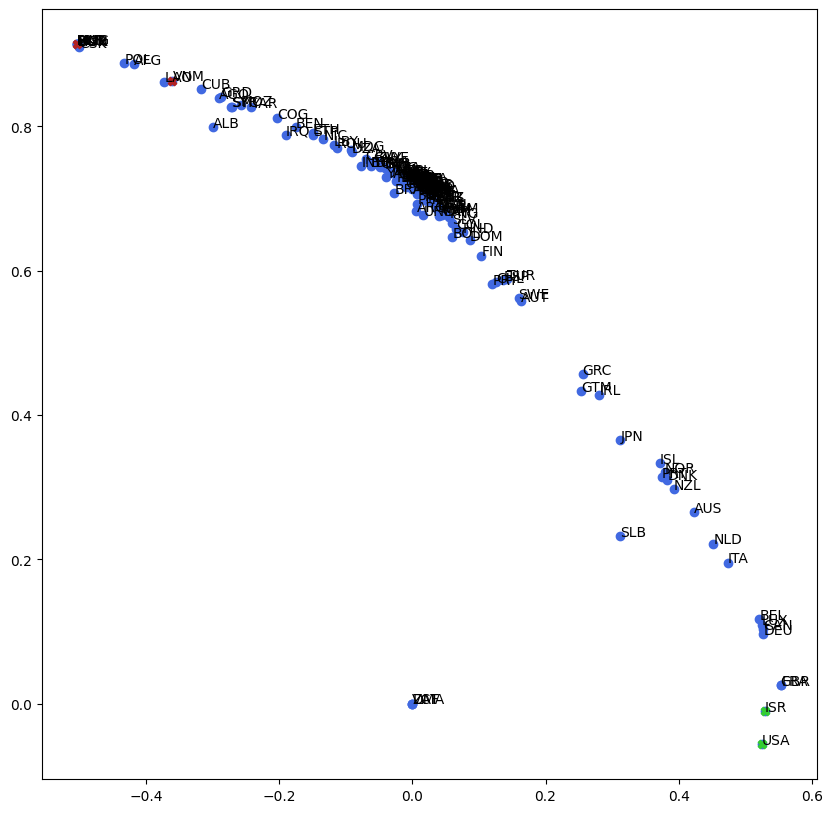

In [6]:
import matplotlib.pyplot as plt

## Calculate GRDPG Embeddings
edge_index = torch.tensor(adj_matrix).nonzero().t().contiguous()
A = torch.tensor(adj_matrix).float()
u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
q = torch.Tensor(list_q)
Q=torch.diag(q)

x_grdpg_orig, cost, k  = GRDPG_GD_Armijo(torch.tensor(x_ase_orig).float(), edge_index, Q, mask_unknown.nonzero().t().contiguous())
x_grdpg_orig = x_grdpg_orig.detach()

country_labels = []
missing_countries = []
for node, data in G_.nodes(data=True):
    if data['type'] == 'country':
        country_labels.append(data['country code'])
        if data['country code'] in ['USA', 'RUS', 'ISR', 'VNM', 'GBR' ,'CUB', 'NLD']:
            print(node,data)
        

        
plt.figure(figsize =(10,10))
plt.scatter(x_grdpg_orig[country_indexes,1],x_grdpg_orig[country_indexes,3], c='royalblue',marker='o',label='Countries')
plt.scatter(x_grdpg_orig[0,1],x_grdpg_orig[0,3], c='limegreen',marker='X')
plt.scatter(x_grdpg_orig[120,1],x_grdpg_orig[120,3], c='limegreen',marker='X')
plt.scatter(x_grdpg_orig[55,1],x_grdpg_orig[55,3], c='firebrick',marker='X')
plt.scatter(x_grdpg_orig[144,1],x_grdpg_orig[144,3], c='firebrick',marker='X')

# Add labels to nodes
for i, label in enumerate(country_labels):
    plt.annotate(label, (x_grdpg_orig[country_indexes,1][i], x_grdpg_orig[country_indexes,3][i]))

# plt.ylim(0.325, 0.52)
# plt.xlim(0.4, 0.6)
plt.show()


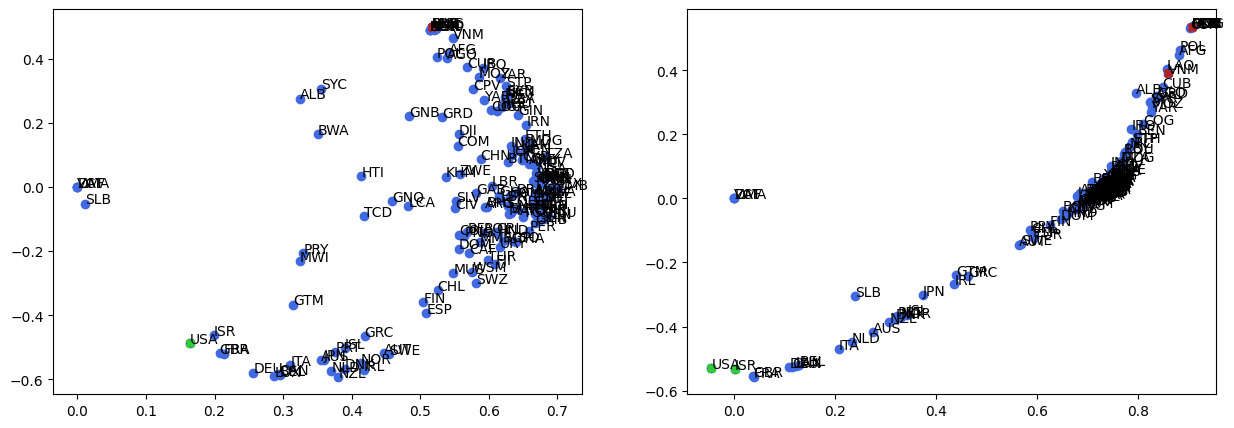

In [7]:
from models.SVD_truncate import align_Xs
x_grdpg_orig_ = align_Xs(x_grdpg_orig, x_ase_orig)

fig, axes = plt.subplots(1, 2, figsize =(15,5))
axes[0].scatter(x_ase_orig[country_indexes,1],x_ase_orig[country_indexes,3], c='royalblue',marker='o',label='Countries')
axes[0].scatter(x_ase_orig[0,1],x_ase_orig[0,3], c='limegreen',marker='X')
axes[0].scatter(x_ase_orig[55,1],x_ase_orig[55,3], c='firebrick',marker='X')
# Add labels to nodes
for i, label in enumerate(country_labels):
    axes[0].annotate(label, (x_ase_orig[country_indexes,1][i], x_ase_orig[country_indexes,3][i]))

# plt.ylim(0.325, 0.52)
# plt.xlim(0.4, 0.6)

axes[1].scatter(x_grdpg_orig_[country_indexes,1],x_grdpg_orig_[country_indexes,3], c='royalblue',marker='o',label='Countries')
axes[1].scatter(x_grdpg_orig_[0,1],x_grdpg_orig_[0,3], c='limegreen',marker='X')
axes[1].scatter(x_grdpg_orig_[120,1],x_grdpg_orig_[120,3], c='limegreen',marker='X')
axes[1].scatter(x_grdpg_orig_[55,1],x_grdpg_orig_[55,3], c='firebrick',marker='X')
axes[1].scatter(x_grdpg_orig_[144,1],x_grdpg_orig_[144,3], c='firebrick',marker='X')

# Add labels to nodes
for i, label in enumerate(country_labels):
    axes[1].annotate(label, (x_grdpg_orig_[country_indexes,1][i], x_grdpg_orig_[country_indexes,3][i]))

# plt.ylim(0.325, 0.52)
# plt.xlim(0.4, 0.6)
plt.show()

In [8]:
mask = torch.ones([num_nodes,num_nodes]).squeeze(0)

# votos = (torch.rand(1, num_nodes) < mask_threshold).int()
mask[120,155:170] = 0 # ISR
mask[155:170,120] = 0 # ISR
mask[33,155:170] = 0 # GBR
mask[155:170,33] = 0 # GBR
mask[35,155:170] = 0 # GBR
mask[155:170,35] = 0 # GBR

# votos = (torch.rand(1, num_nodes) < mask_threshold).int()
mask[144,155:170] = 0 # VNM
mask[155:170,144] = 0 # VNM
mask[4,155:170] = 0 # CUB
mask[155:170,4] = 0 # CUB


mask = mask*mask_unknown
inverted_mask_matrix =  (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask)*mask_unknown

In [9]:
## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
q = torch.Tensor(list_q)
Q=torch.diag(q)

x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()


masked_edge_index = masked_adj.nonzero().t().contiguous()



/home/sofia/lase/lib/python3.10/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


## No random features

In [11]:
from training.run_link_prediction import link_prediction, train, test
from models.link_prediction import Net
import torch_geometric.transforms as T

data_feat = Data(x=features.float(), x_ase=x_ase, x_glase=x_grdpg, x_grdpg=x_grdpg, edge_index=masked_edge_index)

torch.manual_seed(42)
device = 'cuda'
transform = T.Compose([
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                    add_negative_train_samples=False),
])

train_data, val_data, test_data = transform(data_feat)

In [12]:
model_1 = Net(12, 128, 64).to(device)
x_train = train_data.x#torch.concatenate((train_data.x, train_data.x_grdpg), axis=1)
x_val = val_data.x#torch.concatenate((val_data.x, val_data.x_grdpg), axis=1)
x_test = test_data.x#torch.concatenate((test_data.x, test_data.x_grdpg), axis=1)

best_val_auc = final_test_auc = 0
for epoch in range(1, 501):
    loss = train(x_train, train_data, model_1)
    val_auc = test(x_val, val_data, model_1)
    test_auc = test(x_test, test_data, model_1)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        best_model_1 = copy.deepcopy(model_1)
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')
        

## Predict on entire masked graph
x_test = data_feat.x
z = best_model_1.encode(x_test, data_feat.edge_index)
final_edge_index = best_model_1.decode_all(z)
predicted_adj = to_dense_adj(final_edge_index, max_num_nodes=num_nodes).squeeze(0).to('cpu')

indices = torch.where(inverted_mask_matrix)
acc_gcn =((adj_matrix[indices[0], indices[1]]) == (predicted_adj[indices[0], indices[1]])).sum() / indices[0].shape[0]

acc_gcn

Epoch: 050, Loss: 0.6859, Val: 0.5678, Test: 0.5435
Epoch: 100, Loss: 0.6857, Val: 0.6114, Test: 0.5958
Epoch: 150, Loss: 0.6859, Val: 0.6149, Test: 0.5990
Epoch: 200, Loss: 0.6831, Val: 0.6973, Test: 0.7031
Epoch: 250, Loss: 0.6859, Val: 0.6922, Test: 0.6980
Epoch: 300, Loss: 0.6858, Val: 0.6870, Test: 0.6915
Epoch: 350, Loss: 0.6815, Val: 0.6881, Test: 0.6920
Epoch: 400, Loss: 0.6858, Val: 0.6253, Test: 0.6342
Epoch: 450, Loss: 0.6821, Val: 0.6185, Test: 0.6206
Epoch: 500, Loss: 0.6804, Val: 0.6119, Test: 0.6205


tensor(0.6667)

In [18]:
model_2 = Net(d+12, 128, 64).to(device)
x_train = torch.concatenate((train_data.x, train_data.x_ase), axis=1)
x_val = torch.concatenate((val_data.x, val_data.x_ase), axis=1)
x_test = torch.concatenate((test_data.x, test_data.x_ase), axis=1)

best_val_auc = final_test_auc = 0
for epoch in range(1, 501):
    loss = train(x_train, train_data, model_2)
    val_auc = test(x_val, val_data, model_2)
    test_auc = test(x_test, test_data, model_2)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        best_model_2 = copy.deepcopy(model_2)
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')
        

## Predict on entire masked graph
x_test = torch.concatenate((data_feat.x, data_feat.x_ase), axis=1)
z = best_model_2.encode(x_test, data_feat.edge_index)
final_edge_index = best_model_2.decode_all(z)
predicted_adj = to_dense_adj(final_edge_index, max_num_nodes=num_nodes).squeeze(0).to('cpu')

indices = torch.where(inverted_mask_matrix)
acc_ase =((adj_matrix[indices[0], indices[1]]) == (predicted_adj[indices[0], indices[1]])).sum() / indices[0].shape[0]

acc_ase

Epoch: 050, Loss: 0.6925, Val: 0.6271, Test: 0.6473
Epoch: 100, Loss: 0.6859, Val: 0.6584, Test: 0.6666
Epoch: 150, Loss: 0.6777, Val: 0.5705, Test: 0.5627
Epoch: 200, Loss: 0.6738, Val: 0.5933, Test: 0.5878
Epoch: 250, Loss: 0.6670, Val: 0.5895, Test: 0.5806
Epoch: 300, Loss: 0.6669, Val: 0.6361, Test: 0.6291
Epoch: 350, Loss: 0.6687, Val: 0.6281, Test: 0.6211
Epoch: 400, Loss: 0.6662, Val: 0.6371, Test: 0.6309
Epoch: 450, Loss: 0.6705, Val: 0.6468, Test: 0.6443
Epoch: 500, Loss: 0.6719, Val: 0.6189, Test: 0.6184


tensor(0.8704)

In [19]:
model_3 = Net(d+12, 128, 64).to(device)
x_train = torch.concatenate((train_data.x, train_data.x_grdpg), axis=1)
x_val = torch.concatenate((val_data.x, val_data.x_grdpg), axis=1)
x_test = torch.concatenate((test_data.x, test_data.x_grdpg), axis=1)

best_val_auc = final_test_auc = 0
for epoch in range(1, 501):
    loss = train(x_train, train_data, model_3)
    val_auc = test(x_val, val_data, model_3)
    test_auc = test(x_test, test_data, model_3)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        best_model_3 = copy.deepcopy(model_3)
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')
        

## Predict on entire masked graph
x_test = torch.concatenate((data_feat.x, data_feat.x_grdpg), axis=1)
z = best_model_3.encode(x_test, data_feat.edge_index)
final_edge_index = best_model_3.decode_all(z)
predicted_adj = to_dense_adj(final_edge_index, max_num_nodes=num_nodes).squeeze(0).to('cpu')

indices = torch.where(inverted_mask_matrix)
acc_grdpg =((adj_matrix[indices[0], indices[1]]) == (predicted_adj[indices[0], indices[1]])).sum() / indices[0].shape[0]

acc_grdpg

Epoch: 050, Loss: 0.6960, Val: 0.6737, Test: 0.6930
Epoch: 100, Loss: 0.7012, Val: 0.4616, Test: 0.4473
Epoch: 150, Loss: 0.7001, Val: 0.6460, Test: 0.6651
Epoch: 200, Loss: 0.6932, Val: 0.4946, Test: 0.4786
Epoch: 250, Loss: 0.6927, Val: 0.5646, Test: 0.5584
Epoch: 300, Loss: 0.6905, Val: 0.4706, Test: 0.4545
Epoch: 350, Loss: 0.6840, Val: 0.5244, Test: 0.5129
Epoch: 400, Loss: 0.6831, Val: 0.6027, Test: 0.6232
Epoch: 450, Loss: 0.6996, Val: 0.5130, Test: 0.4939
Epoch: 500, Loss: 0.7161, Val: 0.5377, Test: 0.5288


tensor(0.8148)

In [15]:
adj_matrix[4,155:170], adj_matrix[33,155:170], adj_matrix[120,155:170], adj_matrix[144,155:170]

(tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [16]:
predicted_adj[4,155:170], predicted_adj[33,155:170], predicted_adj[120,155:170], predicted_adj[144,155:170]

(tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

## Random features

In [20]:
torch.manual_seed(42)
random_features=torch.rand([num_nodes, 12])
data_rand = Data(x=random_features.float(), x_ase=x_ase, x_glase=x_grdpg, x_grdpg=x_grdpg, edge_index=masked_edge_index)

device = 'cuda'
transform = T.Compose([
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                    add_negative_train_samples=False),
])

train_data, val_data, test_data = transform(data_rand)

In [21]:
model__1 = Net(12, 128, 64).to(device)
x_train = train_data.x
x_val = val_data.x
x_test = test_data.x

best_val_auc = final_test_auc = 0
for epoch in range(1, 501):
    loss = train(x_train, train_data, model__1)
    val_auc = test(x_val, val_data, model__1)
    test_auc = test(x_test, test_data, model__1)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        best_model__1 = copy.deepcopy(model__1)
        
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')
        

## Predict on entire masked graph
x_test = data_rand.x
z = best_model__1.encode(x_test, data_rand.edge_index)
final_edge_index = best_model__1.decode_all(z)
predicted_adj = to_dense_adj(final_edge_index, max_num_nodes=num_nodes).squeeze(0).to('cpu')

indices = torch.where(inverted_mask_matrix)
acc_gcn =((adj_matrix[indices[0], indices[1]]) == (predicted_adj[indices[0], indices[1]])).sum() / indices[0].shape[0]

acc_gcn

Epoch: 050, Loss: 0.7197, Val: 0.6262, Test: 0.6490
Epoch: 100, Loss: 0.7196, Val: 0.6262, Test: 0.6490
Epoch: 150, Loss: 0.7194, Val: 0.6262, Test: 0.6490
Epoch: 200, Loss: 0.7196, Val: 0.6262, Test: 0.6489
Epoch: 250, Loss: 0.7199, Val: 0.6262, Test: 0.6489
Epoch: 300, Loss: 0.7198, Val: 0.6262, Test: 0.6489
Epoch: 350, Loss: 0.7195, Val: 0.6262, Test: 0.6489
Epoch: 400, Loss: 0.7195, Val: 0.6261, Test: 0.6489
Epoch: 450, Loss: 0.7193, Val: 0.6261, Test: 0.6489
Epoch: 500, Loss: 0.7193, Val: 0.6261, Test: 0.6489


tensor(0.6667)

In [22]:
model__2 = Net(d+12, 128, 64).to(device)
x_train = torch.concatenate((train_data.x, train_data.x_ase), axis=1)
x_val = torch.concatenate((val_data.x, val_data.x_ase), axis=1)
x_test = torch.concatenate((test_data.x, test_data.x_ase), axis=1)

best_val_auc = final_test_auc = 0
for epoch in range(1, 501):
    loss = train(x_train, train_data, model__2)
    val_auc = test(x_val, val_data, model__2)
    test_auc = test(x_test, test_data, model__2)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        best_model__2 = copy.deepcopy(model__2)
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')
        

## Predict on entire masked graph
x_test = torch.concatenate((data_rand.x, data_rand.x_ase), axis=1)
z = best_model__2.encode(x_test, data_rand.edge_index)
final_edge_index = best_model__2.decode_all(z)
predicted_adj = to_dense_adj(final_edge_index, max_num_nodes=num_nodes).squeeze(0).to('cpu')

indices = torch.where(inverted_mask_matrix)
acc_ase =((adj_matrix[indices[0], indices[1]]) == (predicted_adj[indices[0], indices[1]])).sum() / indices[0].shape[0]

acc_ase

Epoch: 050, Loss: 0.7260, Val: 0.5994, Test: 0.6149
Epoch: 100, Loss: 0.7236, Val: 0.6219, Test: 0.6374
Epoch: 150, Loss: 0.7164, Val: 0.6228, Test: 0.6374
Epoch: 200, Loss: 0.7103, Val: 0.5839, Test: 0.5969
Epoch: 250, Loss: 0.7081, Val: 0.6081, Test: 0.6212
Epoch: 300, Loss: 0.7082, Val: 0.6374, Test: 0.6515
Epoch: 350, Loss: 0.7044, Val: 0.6422, Test: 0.6663
Epoch: 400, Loss: 0.7036, Val: 0.6456, Test: 0.6700
Epoch: 450, Loss: 0.7025, Val: 0.6507, Test: 0.6752
Epoch: 500, Loss: 0.7046, Val: 0.5688, Test: 0.5898


tensor(0.6667)

In [23]:
model__3 = Net(d+12, 128, 64).to(device)
x_train = torch.concatenate((train_data.x, train_data.x_grdpg), axis=1)
x_val = torch.concatenate((val_data.x, val_data.x_grdpg), axis=1)
x_test = torch.concatenate((test_data.x, test_data.x_grdpg), axis=1)

best_val_auc = final_test_auc = 0
for epoch in range(1, 501):
    loss = train(x_train, train_data, model__3)
    val_auc = test(x_val, val_data, model__3)
    test_auc = test(x_test, test_data, model__3)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        best_model__3 = copy.deepcopy(model__3)
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')
        

## Predict on entire masked graph
x_test = torch.concatenate((data_rand.x, data_rand.x_grdpg), axis=1)
z = best_model__3.encode(x_test, data_rand.edge_index)
final_edge_index = best_model__3.decode_all(z)
predicted_adj = to_dense_adj(final_edge_index, max_num_nodes=num_nodes).squeeze(0).to('cpu')

indices = torch.where(inverted_mask_matrix)
acc_grdpg =((adj_matrix[indices[0], indices[1]]) == (predicted_adj[indices[0], indices[1]])).sum() / indices[0].shape[0]

acc_grdpg

Epoch: 050, Loss: 0.7433, Val: 0.5714, Test: 0.5910
Epoch: 100, Loss: 0.7311, Val: 0.5901, Test: 0.6102
Epoch: 150, Loss: 0.7311, Val: 0.5941, Test: 0.6142
Epoch: 200, Loss: 0.7308, Val: 0.5986, Test: 0.6187
Epoch: 250, Loss: 0.7320, Val: 0.5949, Test: 0.6153
Epoch: 300, Loss: 0.7300, Val: 0.5949, Test: 0.6154
Epoch: 350, Loss: 0.7312, Val: 0.5956, Test: 0.6161
Epoch: 400, Loss: 0.7314, Val: 0.5961, Test: 0.6166
Epoch: 450, Loss: 0.7309, Val: 0.5969, Test: 0.6174
Epoch: 500, Loss: 0.7309, Val: 0.5962, Test: 0.6168


tensor(0.6667)

In [24]:
from training.run_link_prediction import link_prediction

result = link_prediction(edge_index, mask, inverted_mask_matrix, data_feat, 12, d = 4)

GCN acc: 0.6667, ASE acc: 0.9259, GRDPG acc: 0.8519, GLASE acc: 0.9074


In [25]:
from training.run_link_prediction import link_prediction

result = link_prediction(edge_index, mask, inverted_mask_matrix, data_rand, 12, d = 4)

GCN acc: 0.6667, ASE acc: 0.6667, GRDPG acc: 0.6667, GLASE acc: 0.6667


### Unknowns

In [23]:
votes_df[(votes_df['year'] == 1980) & (votes_df['Country'] == 'CUB') & ((votes_df.vote==2) | (votes_df.vote==8))].shape[0] / votes_df[(votes_df['year'] == 1980) & (votes_df['Country'] == 'NLD')].shape[0]

0.1553398058252427

In [24]:
votes_df[(votes_df['year'] == 1980) & (votes_df['Country'] == 'VNM') & ((votes_df.vote==2) | (votes_df.vote==8))].shape[0] / votes_df[(votes_df['year'] == 1980) & (votes_df['Country'] == 'NLD')].shape[0]

0.1941747572815534

In [25]:
votes_df[(votes_df['year'] == 1980) & (votes_df['Country'] == 'ISR') & ((votes_df.vote==2) | (votes_df.vote==8))].shape[0] / votes_df[(votes_df['year'] == 1980) & (votes_df['Country'] == 'NLD')].shape[0]

0.46601941747572817

In [26]:
votes_df[(votes_df['year'] == 1980) & (votes_df['Country'] == 'GBR') & ((votes_df.vote==2) | (votes_df.vote==8))].shape[0] / votes_df[(votes_df['year'] == 1980) & (votes_df['Country'] == 'NLD')].shape[0]

0.42718446601941745

In [27]:
votes_df[(votes_df['year'] == 1980) & (votes_df['Country'] == 'NLD') & ((votes_df.vote==2) | (votes_df.vote==8))].shape[0] / votes_df[(votes_df['year'] == 1980) & (votes_df['Country'] == 'NLD')].shape[0]

0.3106796116504854

# 1990

In [2]:
import numpy as np
import networkx as nx

year = 1990

votes_df = load_un_dataset('data/UNVotes-1.csv', unknown_votes=True)

G = create_un_graphs(votes_df[votes_df.year==year])
G = G.to_undirected()

# rename nodes
mapping = {node: i for i, node in enumerate(G.nodes())}
G_ = nx.relabel_nodes(G, mapping)

country_indexes = []
res_indexes = []
__features = []

for node, data in G_.nodes(data=True):
    if data["type"] == "country":
        country_indexes.append(node)
        __features.append(data['country_features'])
    else:
        res_indexes.append(node)
        __features.append(data['res_features'])


unknown_edges = []

for u, v, data in G_.edges(data=True):
    if data['unknown']:
        unknown_edges.append((u,v))
        unknown_edges.append((v,u))
    

adj_matrix = nx.adjacency_matrix(G_).todense().astype(int)

_features = np.array(__features)
features = torch.tensor(_features)

In [3]:
## Build mask 

num_nodes = adj_matrix.shape[0]
mask_unknown = torch.ones([num_nodes,num_nodes]).squeeze(0)

for u, v, data in G_.edges(data=True):
    if data['unknown']:
        mask_unknown[u,v] = 0
        mask_unknown[v,u] = 0 # Error aca antes

for u,v in unknown_edges:
    if mask_unknown[u,v] != 0:
        print('Error')
        
for u, data in G_.nodes(data=True):
    if data['type'] == 'resolution':
        print(u, data)

1 {'issue code': 'N/A', 'color': 'black', 'important vote': False, 'type': 'resolution', 'res_features': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
160 {'issue code': 'co', 'color': 'orchid', 'important vote': False, 'type': 'resolution', 'res_features': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])}
161 {'issue code': 'co', 'color': 'orchid', 'important vote': False, 'type': 'resolution', 'res_features': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.])}
162 {'issue code': 'co', 'color': 'orchid', 'important vote': False, 'type': 'resolution', 'res_features': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])}
163 {'issue code': 'co', 'color': 'orchid', 'important vote': False, 'type': 'resolution', 'res_features': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])}
164 {'issue code': 'co', 'color': 'orchid', 'important vote': False, 'type': 'resolution', 'res_features': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])}
165 {'issue code':

In [4]:
## Calculate ASE Embeddings
d = 4

## ASE 
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase_orig = ase.fit_transform(adj_matrix)

## Calculate GRDPG Embeddings
edge_index = torch.tensor(adj_matrix).nonzero().t().contiguous()
A = torch.tensor(adj_matrix).float()
u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
q = torch.Tensor(list_q)
Q=torch.diag(q)

x_grdpg_orig, cost, k  = GRDPG_GD_Armijo(torch.tensor(x_ase_orig).float(), edge_index, Q, mask_unknown.nonzero().t().contiguous())
x_grdpg_orig = x_grdpg_orig.detach()

country_labels = []
missing_countries = []
for node, data in G_.nodes(data=True):
    if data['type'] == 'country':
        country_labels.append(data['country code'])
        if data['country code'] in ['USA', 'RUS', 'ISR', 'VNM', 'GBR' ,'CUB', 'NLD']:
            print(node,data)
        

/home/sofia/lase/lib/python3.10/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


0 {'country code': 'USA', 'continent': 'North America', 'country_features': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'yellow', 'type': 'country'}
4 {'country code': 'CUB', 'continent': 'North America', 'country_features': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'yellow', 'type': 'country'}
36 {'country code': 'GBR', 'continent': 'Europe', 'country_features': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'royalblue', 'type': 'country'}
38 {'country code': 'NLD', 'continent': 'Europe', 'country_features': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'royalblue', 'type': 'country'}
58 {'country code': 'RUS', 'continent': 'Europe', 'country_features': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'royalblue', 'type': 'country'}
124 {'country code': 'ISR', 'continent': 'Asia', 'country_features': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'darkorange', 'type

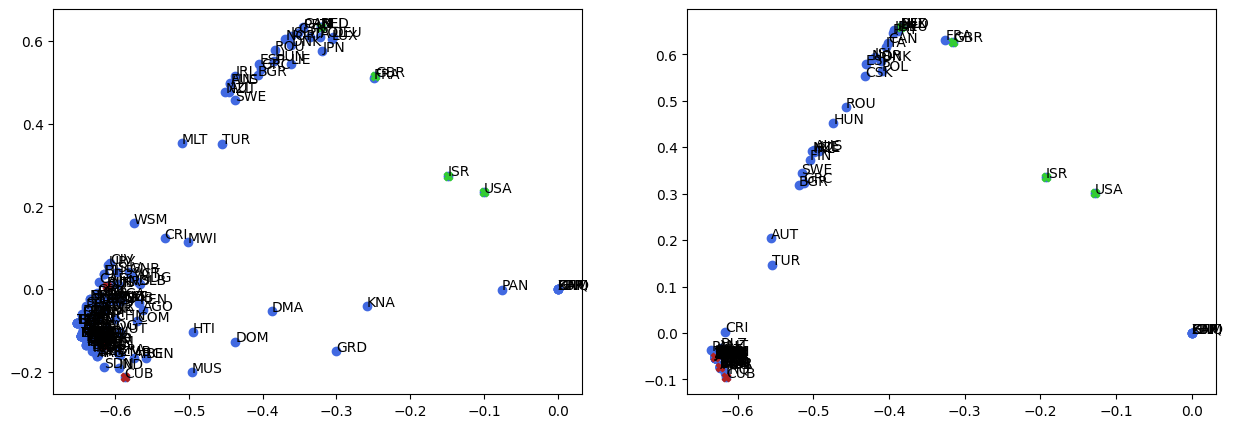

In [5]:
from models.SVD_truncate import align_Xs
x_grdpg_orig_ = align_Xs(x_grdpg_orig, x_ase_orig)

fig, axes = plt.subplots(1, 2, figsize =(15,5))
axes[0].scatter(x_ase_orig[country_indexes,1],x_ase_orig[country_indexes,3], c='royalblue',marker='o',label='Countries')
axes[0].scatter(x_ase_orig[0,1],x_ase_orig[0,3], c='limegreen',marker='X')
axes[0].scatter(x_ase_orig[36,1],x_ase_orig[36,3], c='limegreen',marker='X')
axes[0].scatter(x_ase_orig[38,1],x_ase_orig[38,3], c='limegreen',marker='X')
axes[0].scatter(x_ase_orig[124,1],x_ase_orig[124,3], c='limegreen',marker='X')
axes[0].scatter(x_ase_orig[58,1],x_ase_orig[58,3], c='firebrick',marker='X')
axes[0].scatter(x_ase_orig[4,1],x_ase_orig[4,3], c='firebrick',marker='X')
axes[0].scatter(x_ase_orig[147,1],x_ase_orig[147,3], c='firebrick',marker='X')
# Add labels to nodes
for i, label in enumerate(country_labels):
    axes[0].annotate(label, (x_ase_orig[country_indexes,1][i], x_ase_orig[country_indexes,3][i]))

# plt.ylim(0.325, 0.52)
# plt.xlim(0.4, 0.6)

axes[1].scatter(x_grdpg_orig_[country_indexes,1],x_grdpg_orig_[country_indexes,3], c='royalblue',marker='o',label='Countries')
axes[1].scatter(x_grdpg_orig_[0,1],x_grdpg_orig_[0,3], c='limegreen',marker='X')
axes[1].scatter(x_grdpg_orig_[36,1],x_grdpg_orig_[36,3], c='limegreen',marker='X')
axes[1].scatter(x_grdpg_orig_[38,1],x_grdpg_orig_[38,3], c='limegreen',marker='X')
axes[1].scatter(x_grdpg_orig_[124,1],x_grdpg_orig_[124,3], c='limegreen',marker='X')
axes[1].scatter(x_grdpg_orig_[58,1],x_grdpg_orig_[58,3], c='firebrick',marker='X')
axes[1].scatter(x_grdpg_orig_[4,1],x_grdpg_orig_[4,3], c='firebrick',marker='X')
axes[1].scatter(x_grdpg_orig_[147,1],x_grdpg_orig_[147,3], c='firebrick',marker='X')

# Add labels to nodes
for i, label in enumerate(country_labels):
    axes[1].annotate(label, (x_grdpg_orig_[country_indexes,1][i], x_grdpg_orig_[country_indexes,3][i]))

# plt.ylim(0.325, 0.52)
# plt.xlim(0.4, 0.6)
plt.show()

In [6]:
votes_df[(votes_df['year'] == 1990) & (votes_df['Country'] == 'CUB') & ((votes_df.vote==2) | (votes_df.vote==8))].shape[0] / votes_df[(votes_df['year'] == 1990) & (votes_df['Country'] == 'NLD')].shape[0]

0.08139534883720931

In [7]:
votes_df[(votes_df['year'] == 1990) & (votes_df['Country'] == 'VNM') & ((votes_df.vote==2) | (votes_df.vote==8))].shape[0] / votes_df[(votes_df['year'] == 1990) & (votes_df['Country'] == 'NLD')].shape[0]

0.046511627906976744

In [8]:
votes_df[(votes_df['year'] == 1990) & (votes_df['Country'] == 'ISR') & ((votes_df.vote==2) | (votes_df.vote==8))].shape[0] / votes_df[(votes_df['year'] == 1990) & (votes_df['Country'] == 'NLD')].shape[0]

0.36046511627906974

In [9]:
votes_df[(votes_df['year'] == 1990) & (votes_df['Country'] == 'GBR') & ((votes_df.vote==2) | (votes_df.vote==8))].shape[0] / votes_df[(votes_df['year'] == 1990) & (votes_df['Country'] == 'NLD')].shape[0]

0.313953488372093

In [10]:
votes_df[(votes_df['year'] == 1990) & (votes_df['Country'] == 'NLD') & ((votes_df.vote==2) | (votes_df.vote==8))].shape[0] / votes_df[(votes_df['year'] == 1990) & (votes_df['Country'] == 'NLD')].shape[0]

0.3372093023255814

In [16]:
mask_nodes = []
for node, data in G_.nodes(data=True):
    if data['type'] == 'country':
        country_labels.append(data['country code'])
        if data['country code'] in ['USA', 'RUS', 'ISR', 'VNM', 'GBR' ,'CUB', 'NLD']:
            print(node,data)
            mask_nodes.append(node)

0 {'country code': 'USA', 'continent': 'North America', 'country_features': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'yellow', 'type': 'country'}
4 {'country code': 'CUB', 'continent': 'North America', 'country_features': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'yellow', 'type': 'country'}
36 {'country code': 'GBR', 'continent': 'Europe', 'country_features': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'royalblue', 'type': 'country'}
38 {'country code': 'NLD', 'continent': 'Europe', 'country_features': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'royalblue', 'type': 'country'}
58 {'country code': 'RUS', 'continent': 'Europe', 'country_features': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'royalblue', 'type': 'country'}
124 {'country code': 'ISR', 'continent': 'Asia', 'country_features': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'darkorange', 'type

In [22]:
print(res_indexes[:15])

[1, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173]


In [17]:
mask_nodes

[0, 4, 36, 38, 58, 124, 147]

In [11]:
mask = torch.ones([num_nodes,num_nodes]).squeeze(0)

# votos = (torch.rand(1, num_nodes) < mask_threshold).int()
mask[124,160:175] = 0 # ISR
mask[160:175,124] = 0 # ISR
mask[36,160:175] = 0 # GBR
mask[160:175,36] = 0 # GBR
mask[38,160:175] = 0 # GBR
mask[160:175,38] = 0 # GBR

# votos = (torch.rand(1, num_nodes) < mask_threshold).int()
mask[147,160:175] = 0 # VNM
mask[160:175,147] = 0 # VNM
mask[4,160:175] = 0 # CUB
mask[160:175,4] = 0 # CUB


mask = mask*mask_unknown
inverted_mask_matrix =  (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask)*mask_unknown

In [12]:
## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
q = torch.Tensor(list_q)
Q=torch.diag(q)

x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()


masked_edge_index = masked_adj.nonzero().t().contiguous()

/home/sofia/lase/lib/python3.10/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


In [13]:
from training.run_link_prediction import link_prediction, train, test
from models.link_prediction import Net
import torch_geometric.transforms as T

torch.manual_seed(42)
data_feat = Data(x=features.float(), x_ase=x_ase, x_glase=x_grdpg, x_grdpg=x_grdpg, edge_index=masked_edge_index)

random_features=torch.rand([num_nodes, 12])
data_rand = Data(x=random_features.float(), x_ase=x_ase, x_glase=x_grdpg, x_grdpg=x_grdpg, edge_index=masked_edge_index)



In [14]:
from training.run_link_prediction import link_prediction

result = link_prediction(edge_index, mask, inverted_mask_matrix, data_feat, 12, d = 4)

GCN acc: 0.7500, ASE acc: 0.7500, GRDPG acc: 0.7500, GLASE acc: 0.7500


In [1]:
from training.run_link_prediction import link_prediction

result = link_prediction(edge_index, mask, inverted_mask_matrix, data_rand, 12, d = 4)

ModuleNotFoundError: No module named 'training'

# 1955

In [4]:
import sys 
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

from training.run_link_prediction import link_prediction_onu_2

In [5]:
results = link_prediction_onu_2(year = 1955, d=4, unknown_countries = ['ISR', 'GRB', 'NDL', 'CUB', 'TUR', 'VNM'], mask_threshold = 0.3, random_features=False)

[67, 61, 93, 91, 90, 68, 99, 63, 97, 106, 110]
GCN acc: 0.7143, ASE acc: 0.8214, GRDPG acc: 0.8214, GLASE acc: 0.8214


In [2]:
import sys 
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

import torch 
from models.onu_fuctions import load_un_dataset, create_un_graphs, process_un_graph_2
from training.generate_embeddings import generate_embeddings
from torch_geometric.data import Data
from training.run_link_prediction import link_prediction

year = 1990
# unknown_countries = ['ISR', 'GRB', 'NDL', 'CUB', 'TUR', 'VNM']
unknown_countries = ['SUD', 'FRA']
# unknown_countries = ['USA']
mask_threshold = 0.7
d = 4

votes_df = load_un_dataset('data/UNVotes-1.csv', unknown_votes=True)

all_graphs = create_un_graphs(votes_df[votes_df.year==year])

adj_matrix, country_indexes, res_indexes, unknown_edges, features, mask_nodes, mask, selected_resolutions, inverted_mask_matrix, mask_unknown = process_un_graph_2(all_graphs, mask_countries=unknown_countries, mask_threshold=mask_threshold) 
print(selected_resolutions)

num_nodes = adj_matrix.shape[0]
edge_index = torch.tensor(adj_matrix).nonzero().t().contiguous()

# Generate embeddings
x_ase, x_grdpg, x_glase, masked_edge_index = generate_embeddings(adj_matrix, mask, d)


best_model_1, best_model_2, best_model_3, best_model_4, acc_gcn, acc_ase, acc_grdpg, acc_glase = link_prediction(edge_index, mask, inverted_mask_matrix, data, 12, d)

[240, 173, 162, 194, 190, 187, 176, 172, 228, 170, 234, 213, 163, 242, 235, 186, 188, 223, 231, 184, 212, 239, 216, 196, 238, 210, 214, 1, 207, 219, 169, 203, 229, 180, 220, 168, 237, 222, 211, 165, 164, 183, 205, 181, 201, 197, 175, 161, 236, 193, 166, 233, 204, 177, 182, 191, 202, 200, 199, 160]


NameError: name 'data' is not defined

In [14]:
import torch_geometric.transforms as T
from models.link_prediction import train_link_prediction


data = Data(x=features.float(), x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

device = 'cuda'
transform = T.Compose([
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0, is_undirected=True,
                    add_negative_train_samples=False),
])

train_data, val_data, test_data = transform(data)

x_train = train_data.x
x_val = val_data.x
x_test = test_data.x

model = train_link_prediction(x_train, x_val, x_test, train_data, val_data, test_data, 12)


## Predict on entire masked graph
from torch_geometric.utils import to_dense_adj

z = model.encode(data.x, edge_index.to('cuda'))
final_edge_index = model.decode_all(z)

predicted_adj = to_dense_adj(final_edge_index, max_num_nodes=num_nodes).squeeze(0).to('cpu')
indices = torch.where(inverted_mask_matrix)
acc_gcn =(torch.tensor(adj_matrix[indices[0], indices[1]])== (predicted_adj[indices[0], indices[1]])).sum() / indices[0].shape[0]

acc_gcn

tensor(0.7647)

In [15]:
x_train = torch.concatenate((train_data.x, train_data.x_ase), axis=1)
x_val = torch.concatenate((val_data.x, val_data.x_ase), axis=1)

model = train_link_prediction(x_train, x_val, x_test, train_data, val_data, test_data, 12+d)


## Predict on entire masked graph
from torch_geometric.utils import to_dense_adj

x_eval = torch.concatenate((data.x, data.x_ase), axis=1)
z = model.encode(x_eval, edge_index.to('cuda'))
final_edge_index = model.decode_all(z)

predicted_adj = to_dense_adj(final_edge_index, max_num_nodes=num_nodes).squeeze(0).to('cpu')
indices = torch.where(inverted_mask_matrix)
acc_gcn =(torch.tensor(adj_matrix[indices[0], indices[1]])== (predicted_adj[indices[0], indices[1]])).sum() / indices[0].shape[0]

acc_gcn

tensor(0.7647)

In [16]:
x_train = torch.concatenate((train_data.x, train_data.x_grdpg), axis=1)
x_val = torch.concatenate((val_data.x, val_data.x_grdpg), axis=1)

model = train_link_prediction(x_train, x_val, x_test, train_data, val_data, test_data, 12+d)


## Predict on entire masked graph
from torch_geometric.utils import to_dense_adj

x_eval = torch.concatenate((data.x, data.x_grdpg), axis=1)
z = model.encode(x_eval, edge_index.to('cuda'))
final_edge_index = model.decode_all(z)

predicted_adj = to_dense_adj(final_edge_index, max_num_nodes=num_nodes).squeeze(0).to('cpu')
indices = torch.where(inverted_mask_matrix)
acc_gcn =(torch.tensor(adj_matrix[indices[0], indices[1]])== (predicted_adj[indices[0], indices[1]])).sum() / indices[0].shape[0]

acc_gcn

tensor(0.7647)

# Analisis de datos - Selected

In [38]:
import pandas as pd
import ast
import numpy as np

# Specify the path to your CSV file
csv_file_path = 'original_feat_selected_e2e.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path, sep=';', header=None, names = ['Year', 'masked_countries' ,'masked_resolutions', 'GCN', 'ASE', 'GD_GRDPG', 'GLASE','GLASE_e2e'])

# Convert string representation of lists to actual lists
df['GCN'] = df['GCN'].apply(lambda x: ast.literal_eval(x))
df['ASE'] = df['ASE'].apply(lambda x: ast.literal_eval(x))
df['GD_GRDPG'] = df['GD_GRDPG'].apply(lambda x: ast.literal_eval(x))
df['GLASE'] = df['GLASE'].apply(lambda x: ast.literal_eval(x))
df['GLASE_e2e'] = df['GLASE_e2e'].apply(lambda x: ast.literal_eval(x))

# Create a new column with the mean value of each list in 'Column1'
df['GCN_mean'] = df['GCN'].apply(lambda x: sum(x) / len(x))
df['ASE_mean'] = df['ASE'].apply(lambda x: sum(x) / len(x))
df['GD_mean'] = df['GD_GRDPG'].apply(lambda x: sum(x) / len(x))
df['GLASE_mean'] = df['GLASE'].apply(lambda x: sum(x) / len(x))
df['GLASE_e2e_mean'] = df['GLASE_e2e'].apply(lambda x: sum(x) / len(x))

df['GCN_std'] = df['GCN'].apply(lambda x: np.std(x))
df['ASE_std'] = df['ASE'].apply(lambda x: np.std(x))
df['GD_std'] = df['GD_GRDPG'].apply(lambda x: np.std(x))
df['GLASE_std'] = df['GLASE'].apply(lambda x: np.std(x))
df['GLASE_e2e_std'] = df['GLASE_e2e'].apply(lambda x: np.std(x))

df['GCN_mean_std'] = df.apply(lambda row: f"{row['GCN_mean']:.2f} +/- {row['GCN_std']:.2f}", axis=1)
df['ASE_mean_std'] = df.apply(lambda row: f"{row['ASE_mean']:.2f} +/- {row['ASE_std']:.2f}", axis=1)
df['GD_mean_std'] = df.apply(lambda row: f"{row['GD_mean']:.2f} +/- {row['GD_std']:.2f}", axis=1)
df['GLASE_mean_std'] = df.apply(lambda row: f"{row['GLASE_mean']:.2f} +/- {row['GLASE_std']:.2f}", axis=1)
df['GLASE_e2e_mean_std'] = df.apply(lambda row: f"{row['GLASE_e2e_mean']:.2f} +/- {row['GLASE_e2e_std']:.2f}", axis=1)



df[['Year','GCN_mean_std', 'ASE_mean_std', 'GD_mean_std', 'GLASE_mean_std','GLASE_e2e_mean_std']]

,Year,GCN_mean_std,ASE_mean_std,GD_mean_std,GLASE_mean_std,GLASE_e2e_mean_std
0,1946,0.93 +/- 0.04,0.90 +/- 0.05,0.93 +/- 0.04,0.93 +/- 0.05,0.90 +/- 0.08
1,1947,0.59 +/- 0.07,0.82 +/- 0.04,0.81 +/- 0.05,0.83 +/- 0.03,0.78 +/- 0.15
2,1948,0.88 +/- 0.03,0.90 +/- 0.02,0.91 +/- 0.00,0.91 +/- 0.00,0.91 +/- 0.01
3,1949,0.69 +/- 0.04,0.71 +/- 0.03,0.71 +/- 0.03,0.70 +/- 0.03,0.73 +/- 0.04
4,1950,0.79 +/- 0.03,0.77 +/- 0.01,0.79 +/- 0.01,0.79 +/- 0.01,0.80 +/- 0.02
...,...,...,...,...,...,...
67,2014,0.77 +/- 0.06,0.93 +/- 0.01,0.93 +/- 0.01,0.88 +/- 0.07,0.90 +/- 0.06
68,2015,0.92 +/- 0.01,0.95 +/- 0.01,0.93 +/- 0.01,0.92 +/- 0.02,0.93 +/- 0.02
69,2016,0.46 +/- 0.21,0.67 +/- 0.04,0.68 +/- 0.04,0.63 +/- 0.04,0.65 +/- 0.17
70,2017,0.77 +/- 0.03,0.78 +/- 0.02,0.84 +/- 0.03,0.86 +/- 0.02,0.78 +/- 0.10


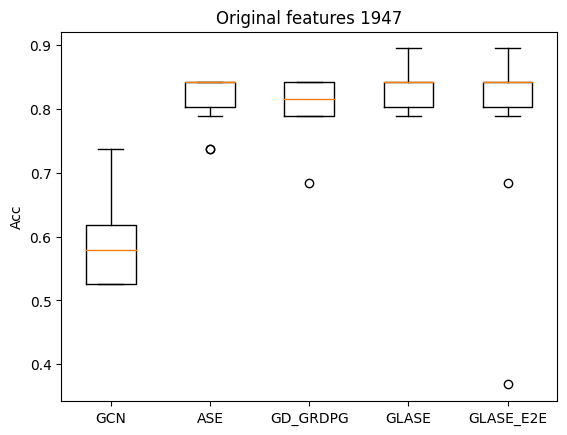

In [39]:
import matplotlib.pyplot as plt

# Data
year = 1947
data_plot = [df[df.Year == year]['GCN'].item(), df[df.Year == year]['ASE'].item(), df[df.Year == year]['GD_GRDPG'].item(), df[df.Year == year]['GLASE'].item(), df[df.Year == year]['GLASE_e2e'].item()        
             ]
plt.boxplot(data_plot)
plt.xticks(range(1, 6), ['GCN','ASE', 'GD_GRDPG', 'GLASE', 'GLASE_E2E'])
# Add title and labels
plt.title(f'Original features {year}')
plt.ylabel('Acc')

# Show the plot
plt.show()

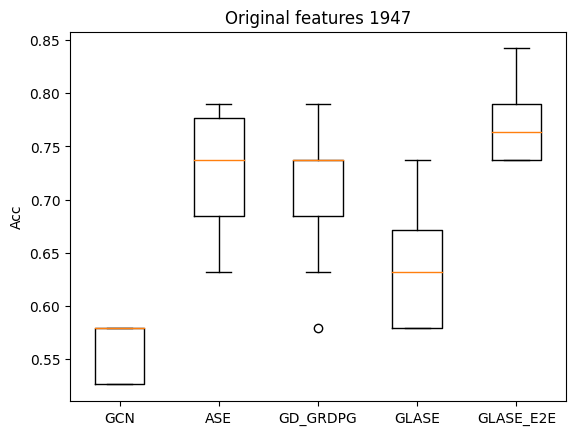

In [40]:
import pandas as pd
import ast
import numpy as np

# Specify the path to your CSV file
csv_file_path = 'original_feat_selected_e2e_test.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path, sep=';', header=None, names = ['Year', 'masked_countries' ,'masked_resolutions', 'GCN', 'ASE', 'GD_GRDPG', 'GLASE','GLASE_e2e'])

# Convert string representation of lists to actual lists
df['GCN'] = df['GCN'].apply(lambda x: ast.literal_eval(x))
df['ASE'] = df['ASE'].apply(lambda x: ast.literal_eval(x))
df['GD_GRDPG'] = df['GD_GRDPG'].apply(lambda x: ast.literal_eval(x))
df['GLASE'] = df['GLASE'].apply(lambda x: ast.literal_eval(x))
df['GLASE_e2e'] = df['GLASE_e2e'].apply(lambda x: ast.literal_eval(x))

# Create a new column with the mean value of each list in 'Column1'
df['GCN_mean'] = df['GCN'].apply(lambda x: sum(x) / len(x))
df['ASE_mean'] = df['ASE'].apply(lambda x: sum(x) / len(x))
df['GD_mean'] = df['GD_GRDPG'].apply(lambda x: sum(x) / len(x))
df['GLASE_mean'] = df['GLASE'].apply(lambda x: sum(x) / len(x))
df['GLASE_e2e_mean'] = df['GLASE_e2e'].apply(lambda x: sum(x) / len(x))

df['GCN_std'] = df['GCN'].apply(lambda x: np.std(x))
df['ASE_std'] = df['ASE'].apply(lambda x: np.std(x))
df['GD_std'] = df['GD_GRDPG'].apply(lambda x: np.std(x))
df['GLASE_std'] = df['GLASE'].apply(lambda x: np.std(x))
df['GLASE_e2e_std'] = df['GLASE_e2e'].apply(lambda x: np.std(x))

df['GCN_mean_std'] = df.apply(lambda row: f"{row['GCN_mean']:.2f} +/- {row['GCN_std']:.2f}", axis=1)
df['ASE_mean_std'] = df.apply(lambda row: f"{row['ASE_mean']:.2f} +/- {row['ASE_std']:.2f}", axis=1)
df['GD_mean_std'] = df.apply(lambda row: f"{row['GD_mean']:.2f} +/- {row['GD_std']:.2f}", axis=1)
df['GLASE_mean_std'] = df.apply(lambda row: f"{row['GLASE_mean']:.2f} +/- {row['GLASE_std']:.2f}", axis=1)
df['GLASE_e2e_mean_std'] = df.apply(lambda row: f"{row['GLASE_e2e_mean']:.2f} +/- {row['GLASE_e2e_std']:.2f}", axis=1)



df[['Year','GCN_mean_std', 'ASE_mean_std', 'GD_mean_std', 'GLASE_mean_std','GLASE_e2e_mean_std']]


import matplotlib.pyplot as plt

# Data
year = 1947
data_plot = [df[df.Year == year]['GCN'].item(), df[df.Year == year]['ASE'].item(), df[df.Year == year]['GD_GRDPG'].item(), df[df.Year == year]['GLASE'].item(), df[df.Year == year]['GLASE_e2e'].item()        
             ]
plt.boxplot(data_plot)
plt.xticks(range(1, 6), ['GCN','ASE', 'GD_GRDPG', 'GLASE', 'GLASE_E2E'])
# Add title and labels
plt.title(f'Original features {year}')
plt.ylabel('Acc')

# Show the plot
plt.show()

In [30]:
import pandas as pd
import ast
import numpy as np 

# Specify the path to your CSV file
csv_file_path = 'random_feat_selected_e2e.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path, sep=';', header=None, names = ['Year', 'masked_countries' ,'masked_resolutions', 'GCN', 'ASE', 'GD_GRDPG', 'GLASE','GLASE_e2e'])

# Convert string representation of lists to actual lists
df['GCN'] = df['GCN'].apply(lambda x: ast.literal_eval(x))
df['ASE'] = df['ASE'].apply(lambda x: ast.literal_eval(x))
df['GD_GRDPG'] = df['GD_GRDPG'].apply(lambda x: ast.literal_eval(x))
df['GLASE'] = df['GLASE'].apply(lambda x: ast.literal_eval(x))
df['GLASE_e2e'] = df['GLASE_e2e'].apply(lambda x: ast.literal_eval(x))

# Create a new column with the mean value of each list in 'Column1'
df['GCN_mean'] = df['GCN'].apply(lambda x: sum(x) / len(x))
df['ASE_mean'] = df['ASE'].apply(lambda x: sum(x) / len(x))
df['GD_mean'] = df['GD_GRDPG'].apply(lambda x: sum(x) / len(x))
df['GLASE_mean'] = df['GLASE'].apply(lambda x: sum(x) / len(x))
df['GLASE_e2e_mean'] = df['GLASE_e2e'].apply(lambda x: sum(x) / len(x))

df['GCN_std'] = df['GCN'].apply(lambda x: np.std(x))
df['ASE_std'] = df['ASE'].apply(lambda x: np.std(x))
df['GD_std'] = df['GD_GRDPG'].apply(lambda x: np.std(x))
df['GLASE_std'] = df['GLASE'].apply(lambda x: np.std(x))
df['GLASE_e2e_std'] = df['GLASE_e2e'].apply(lambda x: np.std(x))

df['GCN_mean_std'] = df.apply(lambda row: f"{row['GCN_mean']:.2f} +/- {row['GCN_std']:.2f}", axis=1)
df['ASE_mean_std'] = df.apply(lambda row: f"{row['ASE_mean']:.2f} +/- {row['ASE_std']:.2f}", axis=1)
df['GD_mean_std'] = df.apply(lambda row: f"{row['GD_mean']:.2f} +/- {row['GD_std']:.2f}", axis=1)
df['GLASE_mean_std'] = df.apply(lambda row: f"{row['GLASE_mean']:.2f} +/- {row['GLASE_std']:.2f}", axis=1)
df['GLASE_e2e_mean_std'] = df.apply(lambda row: f"{row['GLASE_e2e_mean']:.2f} +/- {row['GLASE_e2e_std']:.2f}", axis=1)



df[['Year','GCN_mean_std', 'ASE_mean_std', 'GD_mean_std', 'GLASE_mean_std', 'GLASE_e2e_mean_std']]

,Year,GCN_mean_std,ASE_mean_std,GD_mean_std,GLASE_mean_std,GLASE_e2e_mean_std
0,1946,0.93 +/- 0.05,0.96 +/- 0.00,0.96 +/- 0.00,0.96 +/- 0.00,0.94 +/- 0.03
1,1947,0.64 +/- 0.05,0.67 +/- 0.21,0.76 +/- 0.15,0.66 +/- 0.20,0.70 +/- 0.21
2,1948,0.71 +/- 0.08,0.79 +/- 0.00,0.79 +/- 0.02,0.79 +/- 0.00,0.79 +/- 0.02
3,1949,0.74 +/- 0.05,0.67 +/- 0.04,0.63 +/- 0.03,0.65 +/- 0.01,0.64 +/- 0.04
4,1950,0.72 +/- 0.10,0.81 +/- 0.00,0.82 +/- 0.02,0.81 +/- 0.00,0.81 +/- 0.01
...,...,...,...,...,...,...
65,2014,0.88 +/- 0.00,0.84 +/- 0.07,0.86 +/- 0.04,0.84 +/- 0.05,0.88 +/- 0.00
66,2015,0.84 +/- 0.00,0.82 +/- 0.03,0.83 +/- 0.03,0.84 +/- 0.00,0.84 +/- 0.05
67,2016,0.76 +/- 0.05,0.59 +/- 0.15,0.76 +/- 0.05,0.77 +/- 0.05,0.69 +/- 0.12
68,2017,0.79 +/- 0.06,0.80 +/- 0.05,0.80 +/- 0.05,0.83 +/- 0.00,0.82 +/- 0.05


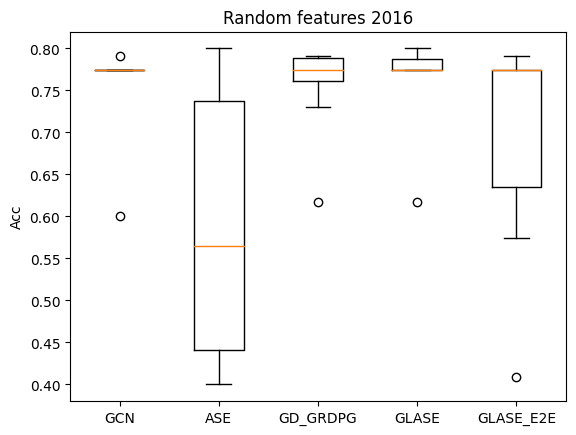

In [31]:
import matplotlib.pyplot as plt

# Data
year = 2016
data_plot = [df[df.Year == year]['GCN'].item(), df[df.Year == year]['ASE'].item(), df[df.Year == year]['GD_GRDPG'].item(), df[df.Year == year]['GLASE'].item(), df[df.Year == year]['GLASE_e2e'].item()        
             ]
plt.boxplot(data_plot)
plt.xticks(range(1, 6), ['GCN','ASE', 'GD_GRDPG', 'GLASE', 'GLASE_E2E'])
# Add title and labels
plt.title(f'Random features {year}')
plt.ylabel('Acc')

# Show the plot
plt.show()


# Analisis datos - random countries

In [32]:
import pandas as pd
import ast
import numpy as np

# Specify the path to your CSV file
csv_file_path = 'original_feat_e2e.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path, sep=';', header=None, names = ['Year', 'masked_countries' ,'masked_resolutions', 'GCN', 'ASE', 'GD_GRDPG', 'GLASE','GLASE_e2e'])

# Convert string representation of lists to actual lists
df['GCN'] = df['GCN'].apply(lambda x: ast.literal_eval(x))
df['ASE'] = df['ASE'].apply(lambda x: ast.literal_eval(x))
df['GD_GRDPG'] = df['GD_GRDPG'].apply(lambda x: ast.literal_eval(x))
df['GLASE'] = df['GLASE'].apply(lambda x: ast.literal_eval(x))
df['GLASE_e2e'] = df['GLASE_e2e'].apply(lambda x: ast.literal_eval(x))

# Create a new column with the mean value of each list in 'Column1'
df['GCN_mean'] = df['GCN'].apply(lambda x: sum(x) / len(x))
df['ASE_mean'] = df['ASE'].apply(lambda x: sum(x) / len(x))
df['GD_mean'] = df['GD_GRDPG'].apply(lambda x: sum(x) / len(x))
df['GLASE_mean'] = df['GLASE'].apply(lambda x: sum(x) / len(x))
df['GLASE_e2e_mean'] = df['GLASE_e2e'].apply(lambda x: sum(x) / len(x))

df['GCN_std'] = df['GCN'].apply(lambda x: np.std(x))
df['ASE_std'] = df['ASE'].apply(lambda x: np.std(x))
df['GD_std'] = df['GD_GRDPG'].apply(lambda x: np.std(x))
df['GLASE_std'] = df['GLASE'].apply(lambda x: np.std(x))
df['GLASE_e2e_std'] = df['GLASE_e2e'].apply(lambda x: np.std(x))

df['GCN_mean_std'] = df.apply(lambda row: f"{row['GCN_mean']:.2f} +/- {row['GCN_std']:.2f}", axis=1)
df['ASE_mean_std'] = df.apply(lambda row: f"{row['ASE_mean']:.2f} +/- {row['ASE_std']:.2f}", axis=1)
df['GD_mean_std'] = df.apply(lambda row: f"{row['GD_mean']:.2f} +/- {row['GD_std']:.2f}", axis=1)
df['GLASE_mean_std'] = df.apply(lambda row: f"{row['GLASE_mean']:.2f} +/- {row['GLASE_std']:.2f}", axis=1)
df['GLASE_e2e_mean_std'] = df.apply(lambda row: f"{row['GLASE_e2e_mean']:.2f} +/- {row['GLASE_e2e_std']:.2f}", axis=1)



df[['Year','GCN_mean_std', 'ASE_mean_std', 'GD_mean_std', 'GLASE_mean_std','GLASE_e2e_mean_std']]

,Year,GCN_mean_std,ASE_mean_std,GD_mean_std,GLASE_mean_std,GLASE_e2e_mean_std
0,1946,0.57 +/- 0.06,0.57 +/- 0.06,0.56 +/- 0.06,0.63 +/- 0.06,0.56 +/- 0.07
1,1947,0.70 +/- 0.03,0.71 +/- 0.01,0.71 +/- 0.01,0.71 +/- 0.01,0.71 +/- 0.03
2,1948,0.93 +/- 0.02,0.92 +/- 0.02,0.93 +/- 0.02,0.93 +/- 0.02,0.92 +/- 0.02
3,1949,0.87 +/- 0.02,0.87 +/- 0.01,0.86 +/- 0.00,0.86 +/- 0.00,0.87 +/- 0.01
4,1950,0.93 +/- 0.01,0.94 +/- 0.01,0.94 +/- 0.01,0.94 +/- 0.02,0.96 +/- 0.02
...,...,...,...,...,...,...
67,2014,0.60 +/- 0.01,0.83 +/- 0.05,0.86 +/- 0.07,0.84 +/- 0.06,0.85 +/- 0.07
68,2015,0.92 +/- 0.02,0.91 +/- 0.03,0.94 +/- 0.02,0.95 +/- 0.02,0.90 +/- 0.05
69,2016,0.58 +/- 0.04,0.77 +/- 0.01,0.78 +/- 0.01,0.79 +/- 0.02,0.69 +/- 0.19
70,2017,0.67 +/- 0.08,0.93 +/- 0.02,0.93 +/- 0.01,0.93 +/- 0.03,0.84 +/- 0.13


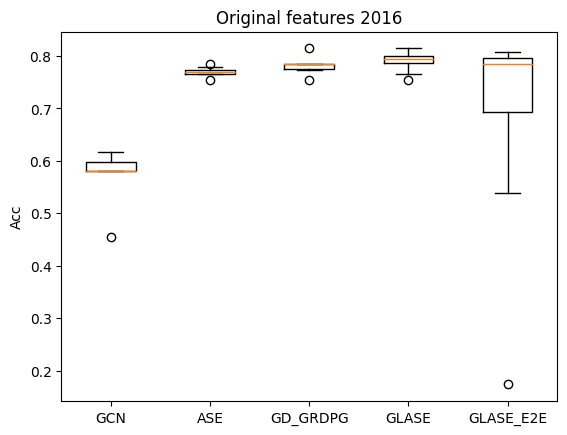

In [33]:
import matplotlib.pyplot as plt

# Data
year = 2016
data_plot = [df[df.Year == year]['GCN'].item(), df[df.Year == year]['ASE'].item(), df[df.Year == year]['GD_GRDPG'].item(), df[df.Year == year]['GLASE'].item(), df[df.Year == year]['GLASE_e2e'].item()        
             ]
plt.boxplot(data_plot)
plt.xticks(range(1, 6), ['GCN','ASE', 'GD_GRDPG', 'GLASE', 'GLASE_E2E'])
# Add title and labels
plt.title(f'Original features {year}')
plt.ylabel('Acc')

# Show the plot
plt.show()


In [34]:
import pandas as pd
import ast
import numpy as np 

# Specify the path to your CSV file
csv_file_path = 'random_feat_e2e.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path, sep=';', header=None, names = ['Year', 'masked_countries' ,'masked_resolutions', 'GCN', 'ASE', 'GD_GRDPG', 'GLASE','GLASE_e2e'])

# Convert string representation of lists to actual lists
df['GCN'] = df['GCN'].apply(lambda x: ast.literal_eval(x))
df['ASE'] = df['ASE'].apply(lambda x: ast.literal_eval(x))
df['GD_GRDPG'] = df['GD_GRDPG'].apply(lambda x: ast.literal_eval(x))
df['GLASE'] = df['GLASE'].apply(lambda x: ast.literal_eval(x))
df['GLASE_e2e'] = df['GLASE_e2e'].apply(lambda x: ast.literal_eval(x))

# Create a new column with the mean value of each list in 'Column1'
df['GCN_mean'] = df['GCN'].apply(lambda x: sum(x) / len(x))
df['ASE_mean'] = df['ASE'].apply(lambda x: sum(x) / len(x))
df['GD_mean'] = df['GD_GRDPG'].apply(lambda x: sum(x) / len(x))
df['GLASE_mean'] = df['GLASE'].apply(lambda x: sum(x) / len(x))
df['GLASE_e2e_mean'] = df['GLASE_e2e'].apply(lambda x: sum(x) / len(x))

df['GCN_std'] = df['GCN'].apply(lambda x: np.std(x))
df['ASE_std'] = df['ASE'].apply(lambda x: np.std(x))
df['GD_std'] = df['GD_GRDPG'].apply(lambda x: np.std(x))
df['GLASE_std'] = df['GLASE'].apply(lambda x: np.std(x))
df['GLASE_e2e_std'] = df['GLASE_e2e'].apply(lambda x: np.std(x))

df['GCN_mean_std'] = df.apply(lambda row: f"{row['GCN_mean']:.2f} +/- {row['GCN_std']:.2f}", axis=1)
df['ASE_mean_std'] = df.apply(lambda row: f"{row['ASE_mean']:.2f} +/- {row['ASE_std']:.2f}", axis=1)
df['GD_mean_std'] = df.apply(lambda row: f"{row['GD_mean']:.2f} +/- {row['GD_std']:.2f}", axis=1)
df['GLASE_mean_std'] = df.apply(lambda row: f"{row['GLASE_mean']:.2f} +/- {row['GLASE_std']:.2f}", axis=1)
df['GLASE_e2e_mean_std'] = df.apply(lambda row: f"{row['GLASE_e2e_mean']:.2f} +/- {row['GLASE_e2e_std']:.2f}", axis=1)



df[['Year','GCN_mean_std', 'ASE_mean_std', 'GD_mean_std', 'GLASE_mean_std','GLASE_e2e_mean_std']]

,Year,GCN_mean_std,ASE_mean_std,GD_mean_std,GLASE_mean_std,GLASE_e2e_mean_std
0,1946,0.82 +/- 0.08,0.83 +/- 0.06,0.85 +/- 0.06,0.88 +/- 0.05,0.83 +/- 0.10
1,1947,0.72 +/- 0.03,0.73 +/- 0.03,0.71 +/- 0.03,0.72 +/- 0.04,0.74 +/- 0.04
2,1948,0.59 +/- 0.00,0.89 +/- 0.01,0.88 +/- 0.04,0.88 +/- 0.03,0.88 +/- 0.03
3,1949,0.71 +/- 0.03,0.82 +/- 0.02,0.81 +/- 0.01,0.79 +/- 0.02,0.81 +/- 0.01
4,1950,0.56 +/- 0.04,0.85 +/- 0.02,0.87 +/- 0.02,0.86 +/- 0.02,0.86 +/- 0.02
...,...,...,...,...,...,...
66,2014,0.91 +/- 0.00,0.67 +/- 0.11,0.68 +/- 0.13,0.95 +/- 0.03,0.84 +/- 0.12
67,2015,0.82 +/- 0.03,0.72 +/- 0.02,0.76 +/- 0.05,0.83 +/- 0.02,0.76 +/- 0.07
68,2016,0.78 +/- 0.04,0.87 +/- 0.03,0.80 +/- 0.04,0.83 +/- 0.02,0.82 +/- 0.02
69,2017,0.94 +/- 0.03,0.89 +/- 0.03,0.89 +/- 0.02,0.96 +/- 0.00,0.93 +/- 0.04


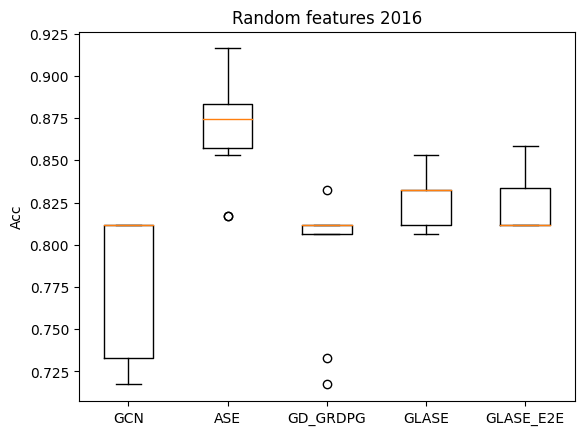

In [35]:
import matplotlib.pyplot as plt

# Data
year = 2016
data_plot = [df[df.Year == year]['GCN'].item(), df[df.Year == year]['ASE'].item(), df[df.Year == year]['GD_GRDPG'].item(), df[df.Year == year]['GLASE'].item(), df[df.Year == year]['GLASE_e2e'].item()        
             ]
plt.boxplot(data_plot)
plt.xticks(range(1, 6), ['GCN','ASE', 'GD_GRDPG', 'GLASE', 'GLASE_E2E'])
# Add title and labels
plt.title(f'Random features {year}')
plt.ylabel('Acc')

# Show the plot
plt.show()